['APPLE' 'GARMIN' 'FitBit' 'SAMSUNG ' 'Noise' 'realme' 'boAt' 'Honor'
 'Crossbeats' 'huami' 'GOQii' 'Fire-Boltt' 'Fastrack']
Enter the brand: APPLE


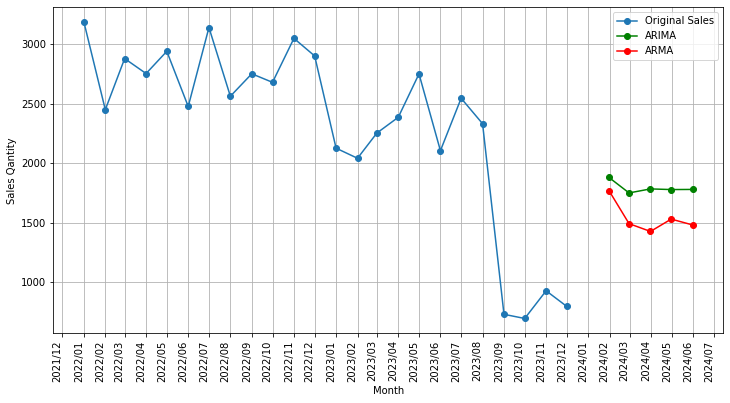

Forecast for Brand: APPLE
ARIMA Forecast:
                Month  ARIMA Forecast
2023-10-01 2024-01-31     1880.435893
2023-11-01 2024-02-29     1750.418471
2023-12-01 2024-03-31     1784.207349
2024-01-01 2024-04-30     1778.758563
2024-02-01 2024-05-31     1779.889731

ARMA Forecast:
                Month  ARMA Forecast
2023-10-01 2024-01-31    1769.631241
2023-11-01 2024-02-29    1491.969519
2023-12-01 2024-03-31    1426.334180
2024-01-01 2024-04-30    1530.243011
2024-02-01 2024-05-31    1480.960226

Difference Percentage (ARIMA_forecasted_values - ARMA_forecasted_values): 16.55%
ARIMA is Better in forecasting sales when compared to ARMA


In [4]:
# Import necessary libraries
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# Function to preprocess the data by converting 'date' column to datetime
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

# Function to replace outliers with median values
def replace_outliers_with_median(df):
    # Replace outliers with median values
    median = df['Sales Qantity'].median()
    std = df['Sales Qantity'].std()
    lower_threshold = median - 3 * std
    upper_threshold = median + 3 * std
    df['Sales Qantity'] = np.where(
        (df['Sales Qantity'] < lower_threshold) | (df['Sales Qantity'] > upper_threshold),
        median, df['Sales Qantity']
    )
    return df

# Function to train ARIMA model
def train_arima_model(train_data, order):
    model = ARIMA(train_data['Sales Qantity'], order=order)
    model_fit = model.fit()
    return model_fit

# Function to make predictions using the trained model
def make_predictions(model_fit, forecast_steps):
    forecast_values = model_fit.forecast(steps=forecast_steps)
    return forecast_values

# Function to plot the forecasted values
def plot_forecast(original_data, forecast_dates, forecast_values_arima, forecast_values_arma):
    plt.figure(figsize=(12, 6))
    plt.plot(original_data.index, original_data['Sales Qantity'], marker='o', linestyle='-', label='Original Sales')
    plt.plot(forecast_dates, forecast_values_arima, marker='o', linestyle='-', label='ARIMA', color='green')
    plt.plot(forecast_dates, forecast_values_arma, marker='o', linestyle='-', label='ARMA', color='red')
    plt.xlabel('Month')
    plt.ylabel('Sales Qantity')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90, ha='right')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
    plt.show()

# Function to run forecasts for a given brand
def run_forecasts(df, brand, order_arima, order_arma, forecast_steps):
    # Filter data by brand
    filtered_data = df[df['Brand Name'] == brand]

    if filtered_data.empty:
        print(f"No data found for Brand: {brand}")
        return None

    # Resample the data by month with frequency set to 'MS' (Month Start)
    monthly_sales = filtered_data.resample('MS', on='date').sum()

    if len(monthly_sales) == 0:
        print(f"No resampled data for Brand: {brand}")
        return None

    # Split data into training and testing sets
    train_size = int(len(monthly_sales) * 0.9)
    train_data, test_data = monthly_sales.iloc[:train_size], monthly_sales.iloc[train_size:]

    if len(train_data) == 0:
        print(f"No training data for Brand: {brand}")
        return None

    # Train the ARIMA model
    try:
        model_fit_arima = train_arima_model(train_data, order_arima)
    except Exception as e:
        print(f"Error while training ARIMA model for Brand: {brand}")
        print(e)
        return None

    # Train the ARMA model (using ARIMA)
    try:
        model_fit_arma = train_arima_model(train_data, order_arma)
    except Exception as e:
        print(f"Error while training ARMA model for Brand: {brand}")
        print(e)
        return None

    # Make ARIMA predictions
    try:
        forecast_values_arima = make_predictions(model_fit_arima, forecast_steps)
    except Exception as e:
        print(f"Error while making ARIMA predictions for Brand: {brand}")
        print(e)
        return None

    # Make ARMA predictions (using ARIMA)
    try:
        forecast_values_arma = make_predictions(model_fit_arma, forecast_steps)
    except Exception as e:
        print(f"Error while making ARMA predictions for Brand: {brand}")
        print(e)
        return None

    # Generate forecast months
    last_month = monthly_sales.index.max()
    forecast_months = pd.date_range(start=last_month + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Plot the forecast
    plot_forecast(monthly_sales, forecast_months, forecast_values_arima, forecast_values_arma)

    # Create forecast DataFrames
    forecast_df_arima = pd.DataFrame({'Month': forecast_months, 'ARIMA Forecast': forecast_values_arima})
    forecast_df_arma = pd.DataFrame({'Month': forecast_months, 'ARMA Forecast': forecast_values_arma})
    return forecast_df_arima, forecast_df_arma

if __name__ == "__main__":
    # Avoid warnings
    warnings.filterwarnings("ignore")

    # Load the dataset and preprocess it
    df = pd.read_csv("C:/Users/harit/OneDrive/Desktop/Education Folder/3rd year/3rd odd/Project/SALES_DATA.csv")

    df = preprocess_data(df)
    df = replace_outliers_with_median(df)

    # Define the ARIMA and ARMA model orders and forecast steps
    order_arima = (2, 1, 1)
    order_arma = (2, 1, 0)  # Equivalent to ARMA(2, 0)
    forecast_steps = 5

    # Get unique brands
    brands = df['Brand Name'].unique()
    print(brands)

    # User input
    brand = input("Enter the brand: ")

    # Check if the brand is valid
    if brand in brands:
        forecast_df_arima, forecast_df_arma = run_forecasts(df, brand, order_arima, order_arma, forecast_steps)
        if forecast_df_arima is not None and forecast_df_arma is not None:
            print(f"Forecast for Brand: {brand}")
            print("ARIMA Forecast:")
            print(forecast_df_arima)
            print("\nARMA Forecast:")
            print(forecast_df_arma)
            
            # Calculate the difference percentage between ARIMA and ARMA forecasted values
            total_sales_arima = forecast_df_arima['ARIMA Forecast'].sum()
            total_sales_arma = forecast_df_arma['ARMA Forecast'].sum()
            overall_percentage_difference = (total_sales_arima - total_sales_arma) / total_sales_arma * 100
            print("\nDifference Percentage (ARIMA_forecasted_values - ARMA_forecasted_values):","{:.2f}%".format(overall_percentage_difference))
            if overall_percentage_difference > 0:
                print("ARIMA is Better in forecasting sales when compared to ARMA")
            else:
                print("ARMA is Better in forecasting sales when compared to ARIMA")
    else:
        print("Invalid brand.")



['APPLE' 'GARMIN' 'FitBit' 'SAMSUNG ' 'Noise' 'realme' 'boAt' 'Honor'
 'Crossbeats' 'huami' 'GOQii' 'Fire-Boltt' 'Fastrack']
Enter the brand: APPLE


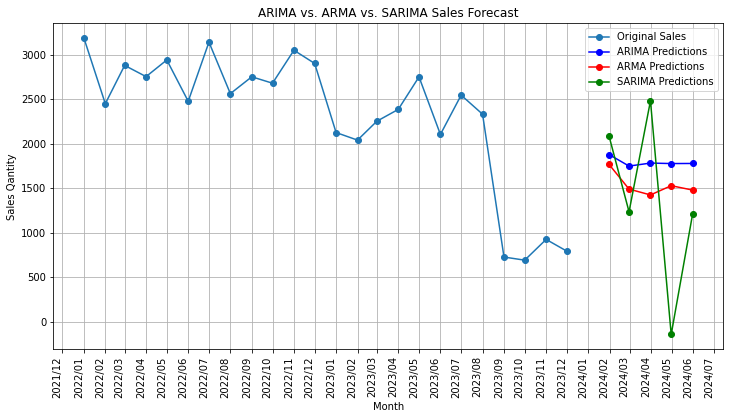

Forecast for Brand: APPLE
ARIMA Forecast:
                Month  ARIMA Forecast
2023-10-01 2024-01-31     1880.435893
2023-11-01 2024-02-29     1750.418471
2023-12-01 2024-03-31     1784.207349
2024-01-01 2024-04-30     1778.758563
2024-02-01 2024-05-31     1779.889731

ARMA Forecast:
                Month  ARMA Forecast
2023-10-01 2024-01-31    1769.631241
2023-11-01 2024-02-29    1491.969519
2023-12-01 2024-03-31    1426.334180
2024-01-01 2024-04-30    1530.243011
2024-02-01 2024-05-31    1480.960226

SARIMA Forecast:
                Month  SARIMA Forecast
2023-10-01 2024-01-31      2089.138945
2023-11-01 2024-02-29      1236.866494
2023-12-01 2024-03-31      2483.224650
2024-01-01 2024-04-30      -140.433903
2024-02-01 2024-05-31      1212.375053


In [6]:
# ARMA ARIMA SARIMA comparison
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Import SARIMA model

# Function to preprocess the data by converting 'date' column to datetime
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

# Function to replace outliers with median values
def replace_outliers_with_median(df):
    # Replace outliers with median values
    median = df['Sales Qantity'].median()
    std = df['Sales Qantity'].std()
    lower_threshold = median - 3 * std
    upper_threshold = median + 3 * std
    df['Sales Qantity'] = np.where(
        (df['Sales Qantity'] < lower_threshold) | (df['Sales Qantity'] > upper_threshold),
        median, df['Sales Qantity']
    )
    return df

# Function to train ARIMA model
def train_arima_model(train_data, order):
    model = ARIMA(train_data['Sales Qantity'], order=order)
    model_fit = model.fit()
    return model_fit

# Function to train SARIMA model
def train_sarima_model(train_data, order, seasonal_order):
    model = SARIMAX(train_data['Sales Qantity'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    return model_fit

# Function to make predictions using the trained model
def make_predictions(model_fit, forecast_steps):
    forecast_values = model_fit.forecast(steps=forecast_steps)
    return forecast_values

# Function to plot the forecasted values
def plot_forecast(original_data, forecast_dates, forecast_values_arima, forecast_values_arma, forecast_values_sarima):
    plt.figure(figsize=(12, 6))
    plt.plot(original_data.index, original_data['Sales Qantity'], marker='o', linestyle='-', label='Original Sales')
    plt.plot(forecast_dates, forecast_values_arima, marker='o', linestyle='-', label='ARIMA Predictions', color='blue')
    plt.plot(forecast_dates, forecast_values_arma, marker='o', linestyle='-', label='ARMA Predictions', color='red')
    plt.plot(forecast_dates, forecast_values_sarima, marker='o', linestyle='-', label='SARIMA Predictions', color='green')
    plt.xlabel('Month')
    plt.ylabel('Sales Qantity')
    plt.title('ARIMA vs. ARMA vs. SARIMA Sales Forecast')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90, ha='right')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
    plt.show()

# Function to run forecasts for a given brand
def run_forecasts(df, brand, order_arima, order_arma, order_sarima, forecast_steps):
    # Filter data by brand
    filtered_data = df[df['Brand Name'] == brand]

    if filtered_data.empty:
        print(f"No data found for Brand: {brand}")
        return None

    # Resample the data by month with frequency set to 'MS' (Month Start)
    monthly_sales = filtered_data.resample('MS', on='date').sum()

    if len(monthly_sales) == 0:
        print(f"No resampled data for Brand: {brand}")
        return None

    # Split data into training and testing sets
    train_size = int(len(monthly_sales) * 0.9)
    train_data, test_data = monthly_sales.iloc[:train_size], monthly_sales.iloc[train_size:]

    if len(train_data) == 0:
        print(f"No training data for Brand: {brand}")
        return None

    # Train the ARIMA model
    try:
        model_fit_arima = train_arima_model(train_data, order_arima)
    except Exception as e:
        print(f"Error while training ARIMA model for Brand: {brand}")
        print(e)
        return None

    # Train the ARMA model (using ARIMA)
    try:
        model_fit_arma = train_arima_model(train_data, order_arma)
    except Exception as e:
        print(f"Error while training ARMA model for Brand: {brand}")
        print(e)
        return None

    # Train the SARIMA model
    try:
        seasonal_order = (1, 1, 1, 12)  # Seasonal order for SARIMA
        model_fit_sarima = train_sarima_model(train_data, order_sarima, seasonal_order)
    except Exception as e:
        print(f"Error while training SARIMA model for Brand: {brand}")
        print(e)
        return None

    # Make ARIMA predictions
    try:
        forecast_values_arima = make_predictions(model_fit_arima, forecast_steps)
    except Exception as e:
        print(f"Error while making ARIMA predictions for Brand: {brand}")
        print(e)
        return None

    # Make ARMA predictions (using ARIMA)
    try:
        forecast_values_arma = make_predictions(model_fit_arma, forecast_steps)
    except Exception as e:
        print(f"Error while making ARMA predictions for Brand: {brand}")
        print(e)
        return None

    # Make SARIMA predictions
    try:
        forecast_values_sarima = make_predictions(model_fit_sarima, forecast_steps)
    except Exception as e:
        print(f"Error while making SARIMA predictions for Brand: {brand}")
        print(e)
        return None

    # Generate forecast months
    last_month = monthly_sales.index.max()
    forecast_months = pd.date_range(start=last_month + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Plot the forecast
    plot_forecast(monthly_sales, forecast_months, forecast_values_arima, forecast_values_arma, forecast_values_sarima)

    # Create forecast DataFrames
    forecast_df_arima = pd.DataFrame({'Month': forecast_months, 'ARIMA Forecast': forecast_values_arima})
    forecast_df_arma = pd.DataFrame({'Month': forecast_months, 'ARMA Forecast': forecast_values_arma})
    forecast_df_sarima = pd.DataFrame({'Month': forecast_months, 'SARIMA Forecast': forecast_values_sarima})
    return forecast_df_arima, forecast_df_arma, forecast_df_sarima

if __name__ == "__main__":
    # Avoid warnings
    warnings.filterwarnings("ignore")

    # Load the dataset and preprocess it
    df = pd.read_csv("C:/Users/harit/OneDrive/Desktop/Education Folder/3rd year/3rd odd/Project/SALES_DATA.csv")

    df = preprocess_data(df)
    df = replace_outliers_with_median(df)

    # Define the ARIMA, ARMA, and SARIMA model orders and forecast steps
    order_arima = (2, 1, 1)
    order_arma = (2, 1, 0)  # Equivalent to ARMA(2, 0)
    order_sarima = (1, 1, 1)
    forecast_steps = 5

    # Get unique brands
    brands = df['Brand Name'].unique()
    print(brands)

    # User input
    brand = input("Enter the brand: ")

    # Check if the brand is valid
    if brand in brands:
        forecast_df_arima, forecast_df_arma, forecast_df_sarima = run_forecasts(df, brand, order_arima, order_arma, order_sarima, forecast_steps)
        if forecast_df_arima is not None and forecast_df_arma is not None and forecast_df_sarima is not None:
            print(f"Forecast for Brand: {brand}")
            print("ARIMA Forecast:")
            print(forecast_df_arima)
            print("\nARMA Forecast:")
            print(forecast_df_arma)
            print("\nSARIMA Forecast:")
            print(forecast_df_sarima)
    else:
        print("Invalid brand.")
